#### By Dimitriy Georgiev

## Assignment Description

The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

> Kaggle Digit Recognizer

My goal for this assignment is to understand fundamentals and build a neural network with Numpy on the MNIST Dataset without the help of deep learning frameworks. The reasoning behind it followed from watching `George Hotz | Programming | MNIST classifier from numpy scratch`

## Dataset Background

The digits have been size-normalized and centered in a fixed-size image. 

The original black and white (bilevel) images from NIST are size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. The images are centered in a 28x28 image by computing the center of mass of the pixels, and translating the image to position this point at the center of the 28x28 field.

With some classification methods (particuarly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass.

The labels values are 0 to 9. 
Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

> The MNIST Database

## Procedure

- Fetch MNIST dataset
- Split data into training set and validation set
- Initialize weights 
- Define activation functions
- Define forward/backward pass
- Train a model
- Adjust hyper-parameters
- Evaluation

The model is a 3-layer feed-forward neural network (FNN), in which the input layer has 784 units (28x28 pixels), the hidden layer has 128-unit activated by ReLU function, and the output layer ends with 10 units activated by softmax function representing a discrete probability distribution for each input.

<div>
<img src="res/fnn.png" width="300"/>
</div>

In [1]:
%pylab inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Fetch MNIST dataset from the web
def fetch(url):
    import requests, gzip, os, hashlib
    from requests.exceptions import HTTPError
    
    file_path = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(file_path):
        with open(file_path, "rb") as file:
            data = file.read()
    else:
        with open(file_path, "wb") as file:
            
            try:
                data = requests.get(url, timeout=5).content
            except HTTPError as http_err:
                print(f'HTTP error occurred: {http_err}')  # Python 3.6
            except Exception as err:
                print(f'Other error occurred: {err}')  # Python 3.6
            else:
                print('OK')
            file.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8)


# Load binary data, apply [0x10] offset to skip the first bytes with descriptive information
# Training set images
# X - Images (60,000)
# Y - Digit Values (0-9)
X_train = np.float32(fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1,28,28)))
Y_train = np.int32(fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[0x8:])
X_test = np.float32(fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1,28,28)))
Y_test = np.int32(fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[0x8:])

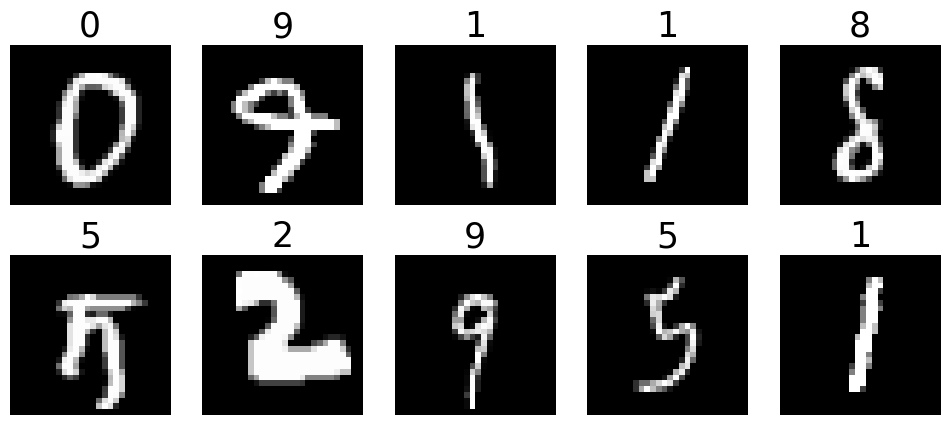

((60000, 28, 28), (60000, 784))

In [3]:
# Display sample images
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,60000,size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i]], cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(Y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

X_train.shape, X_train.reshape((-1, 28*28)).shape

## PyTorch (for comparison)

In [4]:
import torch
from torch import nn as nn
from torch import functional as F
torch.set_printoptions(sci_mode=False)

# Create a Model
class NeuralNetwork(nn.Module):
    def __init__(self): 
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(784, 128, bias=False)
        self.layer_2 = nn.Linear(128, 10, bias=False)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid() # prefer ReLU
        self.softMax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        x = self.softMax(x) # Disable if CrossEntropyLoss -> (LogSoftmax + NLLLoss)
        return x

loss 0.16 accuracy 0.95: 100%|██████████| 1000/1000 [00:05<00:00, 176.89it/s]


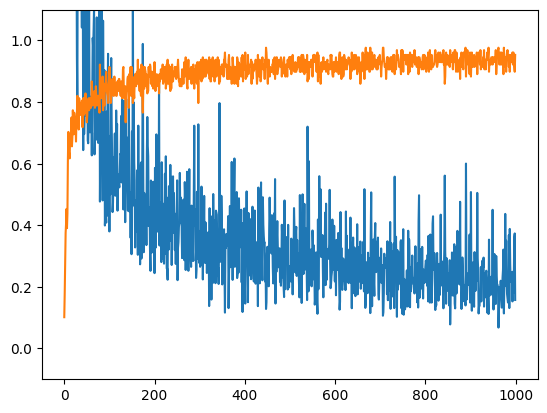

In [5]:
# Training
model = NeuralNetwork()
batch_size = 128
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.NLLLoss(reduction="none")
# optimization = torch.optim.Adam(model.parameters())
optimization = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

losses, accuracies = [], []
t = trange(1000)
for i in t:
    batch = np.random.randint(0, X_train.shape[0], size=batch_size)
    X = torch.tensor(X_train[batch].reshape((-1, 28 * 28))) # flatten, 2-D to 1-D array
    Y = torch.tensor(Y_train[batch]).long()
    model.zero_grad()
    output = model(X)
    digit = torch.argmax(output, dim=1)
    accuracy = (digit == Y).float().mean()
    loss = loss_function(output, Y)
    loss = loss.mean() # if loss function is NLLLoss
    loss.backward()
    optimization.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [6]:
# Evaluation
def evaluate():
    Y_predictions = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
    return (Y_test == Y_predictions).mean()

In [7]:
evaluate()

0.9316

## Numpy Only

### Neural Network

In [8]:
class NumpyNeuralNetwork():
    """
    A class used to represent a Neural Network

    Attributes
    ----------
        sizes : list
            Number of nodes (neurons) in each layer of the NN [input, hidden, out]
        epochs : int
            Number of times the dataset is passed forward and backward (trained) through the NN (default: 1000)
        batch_size : int
            Number of training samples present in a single iteration (default: 128)
        learning_rate : float
            Hyperparameter controlling how much the model is changed on each epoch (default: 0.001)
            
    Methods
    -------
        initialization()
            Initializes parameters and weights of the NN, i.e. prepare transformation matrices for forward pass 
    """
    
    def __init__(self, sizes, epochs=1000, batch_size=128, learning_rate=0.001):
        self.sizes           = sizes
        self.epochs          = epochs
        self.batch_size      = batch_size
        self.learning_rate   = learning_rate
        
        self.weights         = self.__initialization()
        
    def __initialization(self, method=0):
        """ 
        Initializes weights of the NN (for Sigmoid, TanH, or ReLU activation functions)

        Parameters
        ----------
            distribution : int
                Determines the underlying distribution from which the weights are initialized.
                If activaiton function is Sigmoid or TanH, use Xavier or normalized Xavier
                If activation function is ReLU, use Kaiming 
                (Initialization is important)
        """
        input_nodes     = self.sizes[0]
        hidden_nodes    = self.sizes[1]
        output_nodes    = self.sizes[2]
        
        weights = {}
        if (method == 0):
            # Weights drawn randomly from a uniform distribution (Xavier)
            weights = {
                'W1' : np.random.uniform(low=-1., high=1, size=(hidden_nodes, input_nodes))  * np.sqrt(1. / input_nodes),
                'W2' : np.random.uniform(low=-1., high=1, size=(output_nodes, hidden_nodes)) * np.sqrt(1. / hidden_nodes),
            }
        elif (method == 1):
            # Weights drawn randomly from a uniform distribution (normalized Xavier)
            weights = {
                'W1' : np.random.uniform(low=-1., high=1, size=(hidden_nodes, input_nodes))  * (np.sqrt(6.) / np.sqrt(hidden_nodes + input_nodes)),
                'W2' : np.random.uniform(low=-1., high=1, size=(output_nodes, hidden_nodes)) * (np.sqrt(6.) / np.sqrt(output_nodes + hidden_nodes)),
            }
        elif (method == 2):
            # Weights drawn randomly from a gaussian distribution (Kaiming He)
            weights = {
                'W1' : np.random.randn(hidden_nodes, input_nodes)  * np.sqrt(2. / input_nodes),
                'W2' : np.random.randn(output_nodes, hidden_nodes) * np.sqrt(2. / hidden_nodes),
            }
        
        return weights

### Feedforward

#### Activation functions

In [9]:
def sigmoid(x, derivative=False):
    if derivative:
        return (np.exp(-x))/((np.exp(-x)+1)**2)
    return 1/(1 + np.exp(-x))

def softmax(x):
    # Numerically stable with large exponentials
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0)

def ReLU(x, derivative=False):
    if derivative:
        return 1. * (x > 0)
    return x * (x > 0)

def logSumExp(x):
    # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))

def logSoftMax(x):
    # Improved numerical performace and gradient optimization compared to SoftMax
    return x - logSumExp(x)

In [71]:
def forward_backward(weights, x_train, y_train):
    N = len(y_train) # Number of images
    categories = 10      # Possible outcomes, digits [0-10], hence 10 columns
    output = np.zeros((N, categories), np.float32)
    
    for index, value in zip(range(N), y_train):
        output[index, value] = 1
    
    # forward pass
    
    # input layer to hidden layer
    z1 = weights["W1"] @ x_train 
    a1 = ReLU(z1)
    
    # hidden layer to output layer
    z2 = weights["W2"] @ a1
    a2 = logSoftMax(z2)
    print(a2)
    error = (-output * a2.T)
    print(error.shape)
    x_loss = (-output.T * y_train).mean(axis=1)
    
    # backward pass
    #d_output = -output / len(y_train)
    #print(d_output.shape, x_lsm.shape)
    
    # derivative of logsoftmax
    #d_x_lsm = d_output - np.exp(x_lsm.T) * d_output.sum(axis=1).reshape((-1, 1))
    
    # derivative of layer_2
    #d_layer2 = x_relu @ d_x_lsm
    #d_x_relu = d_x_lsm @ x_layer2
    #print(d_x_relu.shape)
    
    # derivative of relu
    #d_x_layer1 = (x_relu > 0).astype(np.float32) @ d_x_relu
    
    # derivative of l1
    #d_layer1 = x_train @ d_x_layer1.T
    
    #return x_loss, x_layer2, d_layer1, d_layer2

In [72]:
nn = NumpyNeuralNetwork(sizes=[784,128,10])
s = [0,1,2,3]
forward_backward(nn.weights, X_train[s].reshape((-1, 28*28)).T, Y_train[s])

[[-2.92262153e+01 -3.38945612e+01 -3.15792213e+01 -3.34242673e+00]
 [-3.57602588e+01 -4.27281127e+01 -5.82182819e+01 -3.47054351e+01]
 [-5.85787698e+01 -8.06051001e+01 -4.30701081e+01 -4.91680574e+01]
 [-9.10774538e+00 -4.58771352e+00 -4.91784258e+01 -3.80729266e+01]
 [-1.25411568e+01 -3.57485100e+01 -2.57142439e+01 -4.67176040e-02]
 [-4.23727116e+01 -2.84368767e+01 -3.12940741e+01 -2.23138409e+01]
 [-4.94316821e+01 -7.73757895e+01 -2.47144628e+01 -2.74810617e+01]
 [-3.51905745e+01 -2.32675186e+01 -1.60078314e+01 -7.00299242e+01]
 [-5.45437851e+01 -8.66587980e+01 -3.21543066e+01 -2.20071200e+01]
 [-1.34352892e+01 -2.53398613e+01 -1.86354504e+01 -1.90989383e+01]]
(4, 10)


### Backpropagation

### Training

In [12]:
np.random.seed(1337)

losses, accuracies = [], []
t = trange(100)
for i in t:
    samp = np.random.randint(0, X_train.shape[0], size=(nn.batch_size))
    X = X_train[samp].reshape((-1, 28*28)).T
    Y = Y_train[samp]
    x_loss, x_l2, d_l1, d_l2 = forward_backward(nn.weights, X, Y)
  
    cat = np.argmax(x_l2)
    accuracy = (cat == Y).mean()
  
    # SGD
    l1 = l1 - nn.learning_rate*d_l1
    l2 = l2 - nn.learning_rate*d_l2
  
    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plot(losses)
plot(accuracies)


  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 [43.8426451  10.51422767 14.23453482 ... 33.77083298 -0.
  51.07680175]
 [47.88448223 -0.         17.18494388 ... 11.6487911  10.39103296
  -0.        ]
 ...
 [ 6.46549875 -0.         11.99887598 ... -0.          2.34110377
  -0.        ]
 [-0.          8.0680076  -0.         ... -0.          8.64761989
  -0.        ]
 [66.64661989 98.50681064 46.10204077 ... -0.         37.13461885
  28.50943034]]


TypeError: cannot unpack non-iterable NoneType object

### Evaluation

In [ ]:
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)

# copy weights from pytorch
# Use [:] for deep copy, instead of address only 
l1[:] = model.layer_1.weight.detach().numpy().transpose()
l2[:] = model.layer_2.weight.detach().numpy().transpose()

In [ ]:
def forward(x):
    x = x @ l1
    x = np.maximum(x, 0)
    x = x @ l2
    return x

Y_test_predictions = np.argmax(forward(X_test.reshape((-1, 28*28))), axis=1)
(Y_test == Y_test_predictions).mean()

## References

Build Neural Network from scratch with Numpy on MNIST Dataset, 2018 https://zhenye-na.github.io/2018/09/09/build-neural-network-with-mnist-from-scratch.html

Neural networks from scratch, 2020 https://developer.ibm.com/technologies/artificial-intelligence/articles/neural-networks-from-scratch